In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import random
import math
import psutil
import pickle

from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder

In [3]:
metadata_dtype = {'site_id':"uint8",'building_id':'uint16','square_feet':'float32','year_built':'float32','floor_count':"float16"}
weather_dtype = {"site_id":"uint8",'air_temperature':"float16",'cloud_coverage':"float16",'dew_temperature':"float16",'precip_depth_1_hr':"float16",
                 'sea_level_pressure':"float32",'wind_direction':"float16",'wind_speed':"float16"}
train_dtype = {'meter':"uint8",'building_id':'uint16'}

In [4]:
%%time

weather_train = pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv", parse_dates=['timestamp'], dtype=weather_dtype)
weather_test = pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv", parse_dates=['timestamp'], dtype=weather_dtype)

metadata = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv", dtype=metadata_dtype)

train = pd.read_csv("../input/ashrae-energy-prediction/train.csv", parse_dates=['timestamp'], dtype=train_dtype)
test = pd.read_csv("../input/ashrae-energy-prediction/test.csv", parse_dates=['timestamp'], usecols=['building_id','meter','timestamp'], dtype=train_dtype)

print('Size of train_df data', train.shape)
print('Size of weather_train_df data', weather_train.shape)
print('Size of weather_test_df data', weather_test.shape)
print('Size of building_meta_df data', metadata.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)
CPU times: user 41.2 s, sys: 2.86 s, total: 44 s
Wall time: 44.2 s


In [5]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

In [6]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,Electricity,2016-01-01,0.0
1,1,Electricity,2016-01-01,0.0
2,2,Electricity,2016-01-01,0.0
3,3,Electricity,2016-01-01,0.0
4,4,Electricity,2016-01-01,0.0


In [7]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.700012,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.200012,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.200012,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.099976,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.000000,250.0,2.599609


In [8]:
# Dropping floor_count variable as it has 75% missing values
metadata.drop('floor_count',axis=1,inplace=True)

In [9]:
for df in [train, test]:
    df['Month'] = df['timestamp'].dt.month.astype("uint8")
    df['DayOfMonth'] = df['timestamp'].dt.day.astype("uint8")
    df['DayOfWeek'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['Hour'] = df['timestamp'].dt.hour.astype("uint8")

In [10]:
train['meter_reading'] = np.log1p(train['meter_reading'])

In [11]:
metadata['primary_use'].replace({"Healthcare":"Other","Parking":"Other","Warehouse/storage":"Other","Manufacturing/industrial":"Other",
                                "Retail":"Other","Services":"Other","Technology/science":"Other","Food sales and service":"Other",
                                "Utility":"Other","Religious worship":"Other"},inplace=True)
metadata['square_feet'] = np.log1p(metadata['square_feet'])
metadata.drop('year_built',axis=1,inplace=True) # delete instead of fill in gaps

In [12]:
%%time
train = pd.merge(train,metadata,on='building_id',how='left')
test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data+Metadata Shape {}".format(train.shape))
print ("Testing Data+Metadata Shape {}".format(test.shape))
gc.collect()
train = pd.merge(train,weather_train,on=['site_id','timestamp'],how='left')
test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data+Metadata+Weather Shape {}".format(train.shape))
print ("Testing Data+Metadata+Weather Shape {}".format(test.shape))
gc.collect()

Training Data+Metadata Shape (20216100, 11)
Testing Data+Metadata Shape (41697600, 10)
Training Data+Metadata+Weather Shape (20216100, 18)
Testing Data+Metadata+Weather Shape (41697600, 17)
CPU times: user 26.5 s, sys: 8.91 s, total: 35.4 s
Wall time: 35.4 s


0

In [13]:
# Save space
for df in [train,test]:
    df['square_feet'] = df['square_feet'].astype('float16')
    
# Fill NA
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    train[col].fillna(np.nanmean(train[col].tolist()),inplace=True)
    test[col].fillna(np.nanmean(test[col].tolist()),inplace=True)
    
# Drop nonsense entries
# As per the discussion in the following thread, https://www.kaggle.com/c/ashrae-energy-prediction/discussion/117083, there is some discrepancy in the meter_readings for different ste_id's and buildings. It makes sense to delete them
idx_to_drop = list((train[(train['site_id'] == 0) & (train['timestamp'] < "2016-05-21 00:00:00")]).index)
print (len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

# dropping all the electricity meter readings that are 0, after considering them as anomalies.
idx_to_drop = list(train[(train['meter'] == "Electricity") & (train['meter_reading'] == 0)].index)
print(len(idx_to_drop))
train.drop(idx_to_drop,axis='rows',inplace=True)

392857
185592


In [14]:
train.head()

,building_id,meter,timestamp,meter_reading,Month,DayOfMonth,DayOfWeek,Hour,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
103,105,Electricity,2016-01-01,3.190624,1,1,4,0,1,Education,10.835938,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
104,106,Electricity,2016-01-01,0.318163,1,1,4,0,1,Education,8.585938,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
105,106,HotWater,2016-01-01,0.000000,1,1,4,0,1,Education,8.585938,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
106,107,Electricity,2016-01-01,5.171529,1,1,4,0,1,Education,11.484375,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609
107,108,Electricity,2016-01-01,4.524668,1,1,4,0,1,Education,11.312500,3.800781,1.900391,2.400391,0.796387,1020.900024,240.0,3.099609


In [15]:
# Not using constructed features, not dropping correlated ones

In [16]:
train.drop('timestamp',axis=1,inplace=True)
test.drop('timestamp',axis=1,inplace=True)

le = LabelEncoder()

train['meter']= le.fit_transform(train['meter']).astype("uint8")
test['meter']= le.fit_transform(test['meter']).astype("uint8")
train['primary_use']= le.fit_transform(train['primary_use']).astype("uint8")
test['primary_use']= le.fit_transform(test['primary_use']).astype("uint8")

print (train.shape, test.shape)

(19637651, 17) (41697600, 16)


In [17]:
categorical_cols = ['building_id','Month','meter','Hour','primary_use','DayOfWeek','DayOfMonth']

In [18]:
from sklearn.ensemble import RandomForestRegressor as RF
import lightgbm as lgb

def train_site_model(train, site):
    print("Training model for site", site)
    
    train = train.loc[site]
    y = train['meter_reading']
    train.drop('meter_reading',axis=1,inplace=True)
    
    # 0 has too much missing data in certain months, so will throw away the month value to force it to consider temperature and the like for detecting winter times instead of using the month value
    if site == 0:
        train["Month"] = 0
    
    x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.1,random_state=42)
    print (x_train.shape)
    print (y_train.shape)
    print (x_test.shape)
    print (y_test.shape)
    
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_cols)
    lgb_test = lgb.Dataset(x_test, y_test, categorical_feature=categorical_cols)
    del x_train, x_test , y_train, y_test

    params = {'feature_fraction': 0.85, # 0.75
              'bagging_fraction': 0.75,
              'objective': 'regression',
               "num_leaves": 40, # New
              'max_depth': -1,
              'learning_rate': 0.15,
              "boosting_type": "gbdt",
              "bagging_seed": 11,
              "metric": 'rmse',
              "verbosity": -1,
              'reg_alpha': 0.5,
              'reg_lambda': 0.5,
              'random_state': 47
             }

    reg = lgb.train(params, lgb_train, num_boost_round=3000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=100)
    del lgb_train,lgb_test
    ser = pd.DataFrame(reg.feature_importance(),train.columns,columns=['Importance']).sort_values(by='Importance')
    ser['Importance'].plot(kind='bar',figsize=(10,6))
    return reg

In [19]:
indexed_train = train.set_index(["site_id"])

Training model for site 0


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



(613760, 15)
(613760,)
(68196, 15)
(68196,)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.513252	valid_1's rmse: 0.532088
[200]	training's rmse: 0.452889	valid_1's rmse: 0.48543
[300]	training's rmse: 0.416747	valid_1's rmse: 0.46127
[400]	training's rmse: 0.388789	valid_1's rmse: 0.44304
[500]	training's rmse: 0.371158	valid_1's rmse: 0.43419
[600]	training's rmse: 0.354772	valid_1's rmse: 0.425127
[700]	training's rmse: 0.339416	valid_1's rmse: 0.416854
[800]	training's rmse: 0.328285	valid_1's rmse: 0.411888
[900]	training's rmse: 0.316703	valid_1's rmse: 0.406046
[1000]	training's rmse: 0.307079	valid_1's rmse: 0.401141
[1100]	training's rmse: 0.297815	valid_1's rmse: 0.397148
[1200]	training's rmse: 0.290421	valid_1's rmse: 0.394901
[1300]	training's rmse: 0.283336	valid_1's rmse: 0.391564
[1400]	training's rmse: 0.276695	valid_1's rmse: 0.389305
[1500]	training's rmse: 0.270187	valid_1's rmse: 0.386887
[1600]	training's rmse: 0.263709	vali

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(2268331, 15)
(2268331,)
(252037, 15)
(252037,)


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.591536	valid_1's rmse: 0.591802
[200]	training's rmse: 0.534747	valid_1's rmse: 0.537031
[300]	training's rmse: 0.499282	valid_1's rmse: 0.504198
[400]	training's rmse: 0.472278	valid_1's rmse: 0.479802
[500]	training's rmse: 0.453561	valid_1's rmse: 0.462912
[600]	training's rmse: 0.439916	valid_1's rmse: 0.450997
[700]	training's rmse: 0.428325	valid_1's rmse: 0.440998
[800]	training's rmse: 0.41825	valid_1's rmse: 0.432405
[900]	training's rmse: 0.408768	valid_1's rmse: 0.42445
[1000]	training's rmse: 0.399986	valid_1's rmse: 0.417202
[1100]	training's rmse: 0.390876	valid_1's rmse: 0.409748
[1200]	training's rmse: 0.384103	valid_1's rmse: 0.404285
[1300]	training's rmse: 0.377514	valid_1's rmse: 0.399047
[1400]	training's rmse: 0.371695	valid_1's rmse: 0.394494
[1500]	training's rmse: 0.365267	valid_1's rmse: 0.389451
[1600]	training's rmse: 0.360203	valid_1's rmse: 0.385724
[1700]	training's rms

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(2130297, 15)
(2130297,)
(236700, 15)
(236700,)


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.234432	valid_1's rmse: 0.234817
[200]	training's rmse: 0.20821	valid_1's rmse: 0.209808
[300]	training's rmse: 0.194229	valid_1's rmse: 0.196958
[400]	training's rmse: 0.184577	valid_1's rmse: 0.187864
[500]	training's rmse: 0.17791	valid_1's rmse: 0.181577
[600]	training's rmse: 0.172055	valid_1's rmse: 0.17624
[700]	training's rmse: 0.167048	valid_1's rmse: 0.171718
[800]	training's rmse: 0.162572	valid_1's rmse: 0.167822
[900]	training's rmse: 0.158739	valid_1's rmse: 0.164316
[1000]	training's rmse: 0.155223	valid_1's rmse: 0.161154
[1100]	training's rmse: 0.152351	valid_1's rmse: 0.158736
[1200]	training's rmse: 0.149878	valid_1's rmse: 0.156652
[1300]	training's rmse: 0.147568	valid_1's rmse: 0.15473
[1400]	training's rmse: 0.145563	valid_1's rmse: 0.153081
[1500]	training's rmse: 0.143697	valid_1's rmse: 0.151623
[1600]	training's rmse: 0.1418	valid_1's rmse: 0.150026
[1700]	training's rmse: 0

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



(668580, 15)
(668580,)
(74287, 15)
(74287,)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.145186	valid_1's rmse: 0.147368
[200]	training's rmse: 0.127842	valid_1's rmse: 0.131499
[300]	training's rmse: 0.11829	valid_1's rmse: 0.123211
[400]	training's rmse: 0.111296	valid_1's rmse: 0.117332
[500]	training's rmse: 0.106177	valid_1's rmse: 0.113323
[600]	training's rmse: 0.102465	valid_1's rmse: 0.110508
[700]	training's rmse: 0.0989973	valid_1's rmse: 0.107968
[800]	training's rmse: 0.0961956	valid_1's rmse: 0.10604
[900]	training's rmse: 0.0936797	valid_1's rmse: 0.104292
[1000]	training's rmse: 0.0914463	valid_1's rmse: 0.102744
[1100]	training's rmse: 0.0892644	valid_1's rmse: 0.101345
[1200]	training's rmse: 0.0872749	valid_1's rmse: 0.10007
[1300]	training's rmse: 0.0854659	valid_1's rmse: 0.098917
[1400]	training's rmse: 0.0839079	valid_1's rmse: 0.0980142
[1500]	training's rmse: 0.0823132	valid_1's rmse: 0.0970252
[1600]	training's rmse: 0

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



(696377, 15)
(696377,)
(77376, 15)
(77376,)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.372881	valid_1's rmse: 0.376016
[200]	training's rmse: 0.312489	valid_1's rmse: 0.318576
[300]	training's rmse: 0.285866	valid_1's rmse: 0.294536
[400]	training's rmse: 0.266623	valid_1's rmse: 0.27756
[500]	training's rmse: 0.252671	valid_1's rmse: 0.265896
[600]	training's rmse: 0.241353	valid_1's rmse: 0.255922
[700]	training's rmse: 0.232126	valid_1's rmse: 0.248489
[800]	training's rmse: 0.224309	valid_1's rmse: 0.24279
[900]	training's rmse: 0.217528	valid_1's rmse: 0.237749
[1000]	training's rmse: 0.211784	valid_1's rmse: 0.233464
[1100]	training's rmse: 0.206911	valid_1's rmse: 0.230158
[1200]	training's rmse: 0.201832	valid_1's rmse: 0.226603
[1300]	training's rmse: 0.197143	valid_1's rmse: 0.223279
[1400]	training's rmse: 0.193277	valid_1's rmse: 0.220682
[1500]	training's rmse: 0.189591	valid_1's rmse: 0.218196
[1600]	training's rmse: 0.185966	va

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.728618	valid_1's rmse: 0.749313
[200]	training's rmse: 0.640441	valid_1's rmse: 0.669877
[300]	training's rmse: 0.593672	valid_1's rmse: 0.632156
[400]	training's rmse: 0.562719	valid_1's rmse: 0.609054
[500]	training's rmse: 0.53902	valid_1's rmse: 0.593315
[600]	training's rmse: 0.518411	valid_1's rmse: 0.580115
[700]	training's rmse: 0.503861	valid_1's rmse: 0.572433
[800]	training's rmse: 0.489927	valid_1's rmse: 0.564806
[900]	training's rmse: 0.476992	valid_1's rmse: 0.557676
[1000]	training's rmse: 0.465076	valid_1's rmse: 0.552081
[1100]	training's rmse: 0.453252	valid_1's rmse: 0.546688
[1200]	training's rmse: 0.443425	valid_1's rmse: 0.542198
[1300]	training's rmse: 0.433099	valid_1's rmse: 0.537512
[1400]	training's rmse: 0.424002	valid_1's rmse: 0.534526
[1500]	training's rmse: 0.416419	valid_1's rmse: 0.531618
[1600]	training's rmse: 0.409038	valid_1's rmse: 0.529267
[1700]	training's rm

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.865071	valid_1's rmse: 0.878664
[200]	training's rmse: 0.749791	valid_1's rmse: 0.779734
[300]	training's rmse: 0.690392	valid_1's rmse: 0.737675
[400]	training's rmse: 0.651368	valid_1's rmse: 0.711657
[500]	training's rmse: 0.620317	valid_1's rmse: 0.694171
[600]	training's rmse: 0.591619	valid_1's rmse: 0.675914
[700]	training's rmse: 0.570029	valid_1's rmse: 0.665085
[800]	training's rmse: 0.551565	valid_1's rmse: 0.656643
[900]	training's rmse: 0.532563	valid_1's rmse: 0.646583
[1000]	training's rmse: 0.517149	valid_1's rmse: 0.639593
[1100]	training's rmse: 0.503741	valid_1's rmse: 0.63343
[1200]	training's rmse: 0.49134	valid_1's rmse: 0.627764
[1300]	training's rmse: 0.478624	valid_1's rmse: 0.622427
[1400]	training's rmse: 0.46701	valid_1's rmse: 0.617951
[1500]	training's rmse: 0.456609	valid_1's rmse: 0.614275
[1600]	training's rmse: 0.445953	valid_1's rmse: 0.610145
[1700]	training's rmse

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.284476	valid_1's rmse: 0.289655
[200]	training's rmse: 0.223277	valid_1's rmse: 0.2302
[300]	training's rmse: 0.187617	valid_1's rmse: 0.195294
[400]	training's rmse: 0.163226	valid_1's rmse: 0.171492
[500]	training's rmse: 0.144736	valid_1's rmse: 0.153189
[600]	training's rmse: 0.130398	valid_1's rmse: 0.1394
[700]	training's rmse: 0.117303	valid_1's rmse: 0.126246
[800]	training's rmse: 0.106675	valid_1's rmse: 0.115796
[900]	training's rmse: 0.0973737	valid_1's rmse: 0.106624
[1000]	training's rmse: 0.0898913	valid_1's rmse: 0.099315
[1100]	training's rmse: 0.0827563	valid_1's rmse: 0.0922721
[1200]	training's rmse: 0.0773152	valid_1's rmse: 0.0869489
[1300]	training's rmse: 0.0722794	valid_1's rmse: 0.0821539
[1400]	training's rmse: 0.0680711	valid_1's rmse: 0.0780199
[1500]	training's rmse: 0.0638356	valid_1's rmse: 0.0738683
[1600]	training's rmse: 0.0604464	valid_1's rmse: 0.0706866
[1700]	tr

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(2371083, 15)
(2371083,)
(263454, 15)
(263454,)


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.645551	valid_1's rmse: 0.650382
[200]	training's rmse: 0.586889	valid_1's rmse: 0.592037
[300]	training's rmse: 0.558334	valid_1's rmse: 0.564879
[400]	training's rmse: 0.541805	valid_1's rmse: 0.550778
[500]	training's rmse: 0.531425	valid_1's rmse: 0.542268
[600]	training's rmse: 0.521172	valid_1's rmse: 0.534322
[700]	training's rmse: 0.513352	valid_1's rmse: 0.528764
[800]	training's rmse: 0.507492	valid_1's rmse: 0.525316
[900]	training's rmse: 0.501328	valid_1's rmse: 0.521521
[1000]	training's rmse: 0.49625	valid_1's rmse: 0.519513
[1100]	training's rmse: 0.491283	valid_1's rmse: 0.517204
[1200]	training's rmse: 0.486524	valid_1's rmse: 0.514914
[1300]	training's rmse: 0.482709	valid_1's rmse: 0.513376
[1400]	training's rmse: 0.478467	valid_1's rmse: 0.51147
[1500]	training's rmse: 0.474389	valid_1's rmse: 0.509927
[1600]	training's rmse: 0.470641	valid_1's rmse: 0.508868
[1700]	training's rms

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.786143	valid_1's rmse: 0.820981
[200]	training's rmse: 0.713827	valid_1's rmse: 0.774379
[300]	training's rmse: 0.666097	valid_1's rmse: 0.745087
[400]	training's rmse: 0.631939	valid_1's rmse: 0.727476
[500]	training's rmse: 0.603629	valid_1's rmse: 0.717175
[600]	training's rmse: 0.582139	valid_1's rmse: 0.710403
[700]	training's rmse: 0.564646	valid_1's rmse: 0.70527
[800]	training's rmse: 0.5474	valid_1's rmse: 0.699311
[900]	training's rmse: 0.529956	valid_1's rmse: 0.694313
[1000]	training's rmse: 0.516771	valid_1's rmse: 0.690111
[1100]	training's rmse: 0.502253	valid_1's rmse: 0.686261
[1200]	training's rmse: 0.490887	valid_1's rmse: 0.683625
[1300]	training's rmse: 0.477306	valid_1's rmse: 0.680688
[1400]	training's rmse: 0.466619	valid_1's rmse: 0.679696
[1500]	training's rmse: 0.455825	valid_1's rmse: 0.677695
[1600]	training's rmse: 0.445829	valid_1's rmse: 0.676532
[1700]	training's rmse

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.442577	valid_1's rmse: 0.484652
[200]	training's rmse: 0.390585	valid_1's rmse: 0.455041
[300]	training's rmse: 0.356947	valid_1's rmse: 0.442241
[400]	training's rmse: 0.32763	valid_1's rmse: 0.4291
[500]	training's rmse: 0.306343	valid_1's rmse: 0.420623
[600]	training's rmse: 0.288272	valid_1's rmse: 0.41396
[700]	training's rmse: 0.272748	valid_1's rmse: 0.408019
[800]	training's rmse: 0.260284	valid_1's rmse: 0.40422
[900]	training's rmse: 0.247953	valid_1's rmse: 0.400629
[1000]	training's rmse: 0.238104	valid_1's rmse: 0.398422
[1100]	training's rmse: 0.229138	valid_1's rmse: 0.395595
[1200]	training's rmse: 0.221369	valid_1's rmse: 0.393859
[1300]	training's rmse: 0.213312	valid_1's rmse: 0.392214
[1400]	training's rmse: 0.206651	valid_1's rmse: 0.390441
[1500]	training's rmse: 0.200434	valid_1's rmse: 0.389348
[1600]	training's rmse: 0.194403	valid_1's rmse: 0.388092
[1700]	training's rmse: 

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.173887	valid_1's rmse: 0.177916
[200]	training's rmse: 0.150044	valid_1's rmse: 0.157387
[300]	training's rmse: 0.137206	valid_1's rmse: 0.147587
[400]	training's rmse: 0.127976	valid_1's rmse: 0.140645
[500]	training's rmse: 0.121697	valid_1's rmse: 0.136476
[600]	training's rmse: 0.11586	valid_1's rmse: 0.132936
[700]	training's rmse: 0.111153	valid_1's rmse: 0.13
[800]	training's rmse: 0.107312	valid_1's rmse: 0.127649
[900]	training's rmse: 0.103706	valid_1's rmse: 0.125362
[1000]	training's rmse: 0.100723	valid_1's rmse: 0.123719
[1100]	training's rmse: 0.0977285	valid_1's rmse: 0.122014
[1200]	training's rmse: 0.0949111	valid_1's rmse: 0.120554
[1300]	training's rmse: 0.0926959	valid_1's rmse: 0.1195
[1400]	training's rmse: 0.0903235	valid_1's rmse: 0.118221
[1500]	training's rmse: 0.0880807	valid_1's rmse: 0.117118
[1600]	training's rmse: 0.0860073	valid_1's rmse: 0.116257
[1700]	training's rm

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(2422700, 15)
(2422700,)
(269189, 15)
(269189,)


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.715341	valid_1's rmse: 0.716189
[200]	training's rmse: 0.646486	valid_1's rmse: 0.650616
[300]	training's rmse: 0.607283	valid_1's rmse: 0.613809
[400]	training's rmse: 0.579087	valid_1's rmse: 0.588329
[500]	training's rmse: 0.560072	valid_1's rmse: 0.572209
[600]	training's rmse: 0.543213	valid_1's rmse: 0.558264
[700]	training's rmse: 0.531182	valid_1's rmse: 0.548522
[800]	training's rmse: 0.520546	valid_1's rmse: 0.540346
[900]	training's rmse: 0.510056	valid_1's rmse: 0.532223
[1000]	training's rmse: 0.500031	valid_1's rmse: 0.524436
[1100]	training's rmse: 0.491532	valid_1's rmse: 0.518098
[1200]	training's rmse: 0.483637	valid_1's rmse: 0.51255
[1300]	training's rmse: 0.476767	valid_1's rmse: 0.507891
[1400]	training's rmse: 0.470212	valid_1's rmse: 0.503357
[1500]	training's rmse: 0.463755	valid_1's rmse: 0.499345
[1600]	training's rmse: 0.456808	valid_1's rmse: 0.494726
[1700]	training's rm

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(2214871, 15)
(2214871,)
(246097, 15)
(246097,)


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.02955	valid_1's rmse: 1.03232
[200]	training's rmse: 0.948192	valid_1's rmse: 0.955147
[300]	training's rmse: 0.901018	valid_1's rmse: 0.911667
[400]	training's rmse: 0.868966	valid_1's rmse: 0.882403
[500]	training's rmse: 0.845596	valid_1's rmse: 0.862203
[600]	training's rmse: 0.825188	valid_1's rmse: 0.84529
[700]	training's rmse: 0.811141	valid_1's rmse: 0.83412
[800]	training's rmse: 0.797484	valid_1's rmse: 0.824281
[900]	training's rmse: 0.785732	valid_1's rmse: 0.815948
[1000]	training's rmse: 0.774323	valid_1's rmse: 0.808039
[1100]	training's rmse: 0.764046	valid_1's rmse: 0.801031
[1200]	training's rmse: 0.754363	valid_1's rmse: 0.794708
[1300]	training's rmse: 0.746318	valid_1's rmse: 0.789418
[1400]	training's rmse: 0.738793	valid_1's rmse: 0.78497
[1500]	training's rmse: 0.731701	valid_1's rmse: 0.780791
[1600]	training's rmse: 0.724637	valid_1's rmse: 0.776978
[1700]	training's rmse: 

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1622363, 15)
(1622363,)
(180263, 15)
(180263,)


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.486595	valid_1's rmse: 0.492414
[200]	training's rmse: 0.45135	valid_1's rmse: 0.461416
[300]	training's rmse: 0.432651	valid_1's rmse: 0.447769
[400]	training's rmse: 0.418361	valid_1's rmse: 0.439316
[500]	training's rmse: 0.40728	valid_1's rmse: 0.433611
[600]	training's rmse: 0.397031	valid_1's rmse: 0.428944
[700]	training's rmse: 0.38983	valid_1's rmse: 0.425656
[800]	training's rmse: 0.383748	valid_1's rmse: 0.42301
[900]	training's rmse: 0.377769	valid_1's rmse: 0.421029
[1000]	training's rmse: 0.371626	valid_1's rmse: 0.418907
[1100]	training's rmse: 0.365556	valid_1's rmse: 0.416664
[1200]	training's rmse: 0.360998	valid_1's rmse: 0.415585
[1300]	training's rmse: 0.356275	valid_1's rmse: 0.415029
[1400]	training's rmse: 0.351604	valid_1's rmse: 0.413878
[1500]	training's rmse: 0.346976	valid_1's rmse: 0.413102
[1600]	training's rmse: 0.342619	valid_1's rmse: 0.412202
[1700]	training's rmse:

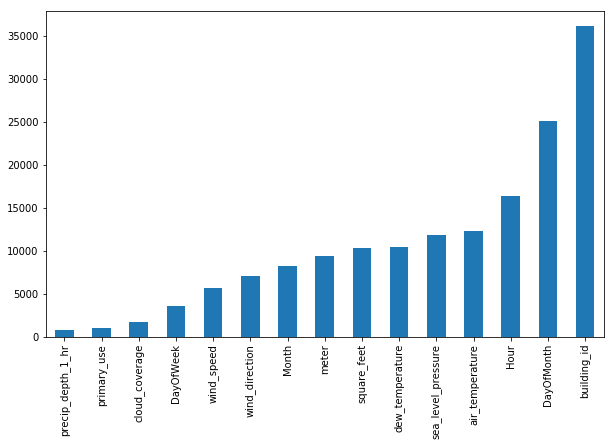

In [20]:
models = []

for i in range(16):
    models.append(train_site_model(indexed_train, i))

In [21]:
Submission = pd.DataFrame(test.index, columns=['row_id'])
Submission['site_id'] = test['site_id']

In [22]:
test.set_index(['site_id'], inplace = True)
Submission.set_index(['site_id'], inplace=True)

In [23]:
%%time
# Couldn't just set them directly to the Submission dataframe because it complains about unmatching lengths, even though they are totally the same length grrr
Predictions = pd.Series(np.zeros(test.shape[0]), test.index)
for i in range(16):
    print("Predicting for site", i)
    Predictions.loc[i] = np.expm1(models[i].predict(test.loc[i]))
Submission['meter_reading'] = Predictions

Predicting for site 0
Predicting for site 1
Predicting for site 2
Predicting for site 3
Predicting for site 4
Predicting for site 5
Predicting for site 6
Predicting for site 7
Predicting for site 8
Predicting for site 9
Predicting for site 10
Predicting for site 11
Predicting for site 12
Predicting for site 13
Predicting for site 14
Predicting for site 15
CPU times: user 3h 35min 59s, sys: 27.8 s, total: 3h 36min 27s
Wall time: 1h 51min 36s


In [24]:
Submission.head()

,row_id,meter_reading
site_id,,
0,0,149.698596
0,1,68.732275
0,2,6.506648
0,3,229.950667
0,4,1363.710670


In [25]:
Submission['meter_reading'].clip(lower=0,upper=None,inplace=True)
Submission.to_csv("model_per_site.csv",index=None)

In [26]:
from IPython.display import FileLink
FileLink('model_per_site.csv')

/kaggle/working/model_per_site.csv

In [27]:
Submission.shape

(41697600, 2)